In [1]:
import os
# os.environ["KERAS_BACKEND"] = "jax"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
# import jax
import keras

from sklearn import metrics

from tqdm.notebook import tqdm
import random

print(tf.__version__)
# print(jax.__version__)

2.16.1


In [2]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? True


In [3]:
SEED = 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
# DATA = "/kaggle/input/leap-atmospheric-physics-ai-climsim"
DATA_NPY = "data"

In [5]:
sample = pl.read_csv('sample_submission.csv', n_rows=1)
TARGETS = sample.select(pl.exclude('sample_id')).columns
print(len(TARGETS))

368


In [6]:
BATCH_SIZE = 4096
random.seed(42)
train_files = [os.path.join(DATA_NPY, "split_%d.npy" % i) for i in range(1,99)]
random.shuffle(train_files)
valid_files = [os.path.join(DATA_NPY, "split_%d.npy" % i) for i in range(99, 102)]
train_options = tf.data.Options()
train_options.deterministic = True

def create_generator(file_paths):
    for file_path in file_paths:
        data = np.load(file_path, allow_pickle=True)
        for sample in data:
            yield sample[:-368], sample[-368:]

def create_dataset_from_npy(file_paths, batch_size=BATCH_SIZE, shuffle_buffer_size=4*BATCH_SIZE, is_training=True):
    dataset = tf.data.Dataset.from_generator(
        lambda: create_generator(file_paths),
        output_signature=(
            tf.TensorSpec(shape=(556,), dtype=tf.float64), 
            tf.TensorSpec(shape=(368,), dtype=tf.float64)
        )
    )
    
    if is_training:
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

# Create train dataset
ds_train = create_dataset_from_npy(train_files, BATCH_SIZE, is_training=True)

# Create validation dataset
ds_valid = create_dataset_from_npy(valid_files, BATCH_SIZE, is_training=False)

In [7]:
norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x).take(1000))

2024-06-18 15:59:38.385960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y).take(1000))

mean_y = norm_y.mean
stdd_y =keras.ops.maximum(1e-10, norm_y.variance ** 0.5)

2024-06-18 16:03:42.672590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
mean_y = tf.cast(mean_y, tf.float64)
stdd_y = tf.cast(stdd_y, tf.float64)

In [10]:
min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)
max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(1000)], 0), 0, keepdims=True)

2024-06-18 16:07:39.406874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 16:11:34.479301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
min_y = tf.cast(min_y, tf.float64)
max_y = tf.cast(max_y, tf.float64)

### Model definition & Training

In [12]:
@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        return keras.ops.mean(keras.ops.clip(self.base_metric.result(), 0.0, 1.0))
        
    def reset_states(self):
        self.base_metric.reset_states()

In [13]:
epochs = 14
learning_rate = 1.1e-3

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    1e-4,
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

In [14]:
import keras
import tensorflow as tf

keras.utils.clear_session()

def x_to_seq(x):
    x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, 0:60 * 6], (-1, 6, 60)), (0, 2, 1))
    x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, 60 * 6 + 16:60 * 9 + 16], (-1, 3, 60)), (0, 2, 1))
    x_flat = keras.ops.reshape(x[:, 60 * 6:60 * 6 + 16], (-1, 1, 16))
    x_flat = keras.ops.repeat(x_flat, 60, axis=1)
    return keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1)

def build_cnn(activation='relu'):    
    return keras.Sequential([
        keras.layers.Conv1D(512, 3, strides=1, padding='same', activation=activation),
        # keras.layers.BatchNormalization(),
        keras.layers.Conv1D(256, 3, strides=1, padding='same', activation=activation),
        # keras.layers.BatchNormalization(),
        keras.layers.Conv1D(128, 3, strides=1, padding='same', activation=activation),
        # keras.layers.BatchNormalization(),
        keras.layers.Conv1D(164, 3, strides=1, padding='same', activation=activation),
        # keras.layers.BatchNormalization(),
    ])

# Current track
X_input = x = keras.layers.Input(shape=(556,), dtype=tf.float64)
x = keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance)(x)
x_seq = x_to_seq(x)

e = e0 = keras.layers.Conv1D(164, 1, padding='same')(x_seq)
e = build_cnn()(e)
# Add global average to allow some communication between all levels even in a small CNN
e = e0 + e + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)
# e = keras.layers.BatchNormalization()(e)
e = e + build_cnn()(e)

p_all = keras.layers.Conv1D(14, 1, padding='same')(e)

p_seq = p_all[:, :, :6]
p_seq = keras.ops.transpose(p_seq, (0, 2, 1))
p_seq = keras.layers.Flatten()(p_seq)
assert p_seq.shape[-1] == 360

# p_flat = p_all[:, :, 6:6 + 8]
# p_flat = keras.ops.mean(p_flat, axis=1)
# assert p_flat.shape[-1] == 8

combined = keras.ops.concatenate([p_seq, x], axis=1)

# add features here

# shallow neural network combining cnn and input
nn = keras.layers.Dense(556+360, activation='relu')(combined) # minus 14 or 16
output = keras.layers.Dense(368, activation='linear')(nn)

# Build & compile
model = keras.Model(inputs=X_input, outputs=output)
model.compile(
    loss='mse', 
    optimizer=keras.optimizers.Adam(lr_scheduler),
    metrics=[ClippedR2Score()]
)

model.build(input_shape=(None, 556))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 556)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 556)       │          0 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 360)       │          0 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180)       │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 16)        │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 6, 60)     │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 3, 60)     │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 16)     │          0 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose           │ (None, 60, 6)     │          0 │ reshape[0][0]     │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_1         │ (None, 60, 3)     │          0 │ reshape_1[0][0]   │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, 60, 16)    │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 25)    │          0 │ transpose[0][0],  │
│ (Concatenate)       │                   │            │ transpose_1[0][0… │
│                     │                   │            │ repeat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 164)   │      4,264 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 60, 164)   │    807,460 │ conv1d[0][0]      │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 164)   │          0 │ conv1d[0][0],     │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1, 164)    │          0 │ sequential[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 164)   │          0 │ add[0][0],        │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 60, 164)   │    807,460 │ add_1[0][0]       │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,798,922 (10.68 MB)

 Trainable params: 2,798,922 (10.68 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# model_path = '/kaggle/input/leapseq2seq/model.keras'
# model = tf.keras.models.load_model(model_path)

In [16]:
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

history = model.fit(
    ds_train_target_normalized,
    validation_data=ds_valid_target_normalized,
    epochs=epochs,
    verbose=1 if is_interactive() else 2,
    callbacks=[
        keras.callbacks.ModelCheckpoint(filepath='models/dualmodel_alt.keras'),
        # keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1, monitor='val_r2_score', mode='max', min_lr=1e-6)
    ]
)

Epoch 1/14
   2415/Unknown 1665s 688ms/step - loss: 0.5507 - r2_score: 0.2298

2024-06-18 16:39:19.630792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 16:39:19.630816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Size/_108]]
/Users/johnny/anaconda3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2415/2415 ━━━━━━━━━━━━━━━━━━━━ 1684s 696ms/step - loss: 0.5506 - r2_score: 0.2298 - val_loss: 0.3563 - val_r2_score: 0.3911
Epoch 2/14


2024-06-18 16:39:38.734026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[compile_loss/mse/Cast/_12]]
2024-06-18 16:39:38.734043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2415/2415 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - loss: 0.3690 - r2_score: 0.4012

2024-06-18 17:08:38.663209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 17:08:38.663231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_24/_70]]


2415/2415 ━━━━━━━━━━━━━━━━━━━━ 1761s 729ms/step - loss: 0.3690 - r2_score: 0.4012 - val_loss: 0.3182 - val_r2_score: 0.4328
Epoch 3/14


2024-06-18 17:08:59.633769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 17:08:59.633793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2415/2415 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - loss: 0.3336 - r2_score: 0.4375

2024-06-18 17:49:11.890401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_24/_70]]
2024-06-18 17:49:11.890420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2415/2415 ━━━━━━━━━━━━━━━━━━━━ 2437s 1s/step - loss: 0.3336 - r2_score: 0.4375 - val_loss: 0.3058 - val_r2_score: 0.4448
Epoch 4/14


2024-06-18 17:49:36.822009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 17:49:36.822029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[functional_3_1/Cast/_2]]


2415/2415 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3199 - r2_score: 0.4516

2024-06-18 18:31:01.866861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 18:31:01.866905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_22/_68]]


2415/2415 ━━━━━━━━━━━━━━━━━━━━ 2510s 1s/step - loss: 0.3199 - r2_score: 0.4516 - val_loss: 0.2911 - val_r2_score: 0.4620
Epoch 5/14


2024-06-18 18:31:27.265410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 18:31:27.265428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape_1/_10]]


2415/2415 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3076 - r2_score: 0.4648

2024-06-18 19:13:53.444717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 19:13:53.444731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_10/_100]]


2415/2415 ━━━━━━━━━━━━━━━━━━━━ 2572s 1s/step - loss: 0.3076 - r2_score: 0.4648 - val_loss: 0.2817 - val_r2_score: 0.4712
Epoch 6/14


2024-06-18 19:14:19.274952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-18 19:14:19.274981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Size/_8]]


 734/2415 ━━━━━━━━━━━━━━━━━━━━ 24:46 884ms/step - loss: 0.2976 - r2_score: 0.4740

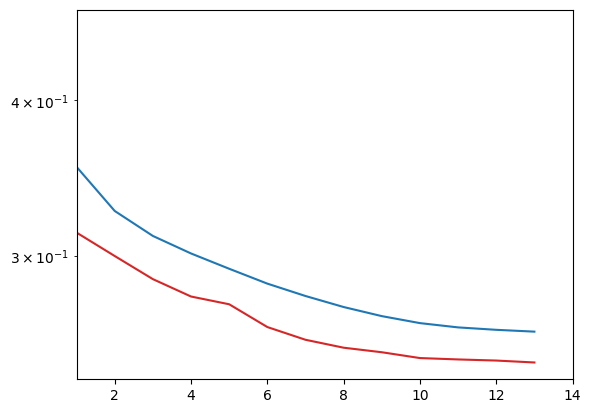

In [ ]:
plt.plot(history.history['loss'], color='tab:blue')
plt.plot(history.history['val_loss'], color='tab:red')
plt.xlim(1, epochs)
plt.yscale('log');

In [ ]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

2024-06-18 15:49:55.528888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step


2024-06-18 15:50:02.136183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/johnny/anaconda3/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
p_valid.numpy()[0]

array([ 4.54095873e-05,  1.28923913e-05,  4.79278906e-05,  1.18862407e-04,
        1.09901216e-04,  1.32729743e-04,  1.29195968e-04,  1.12650613e-04,
        7.80620289e-05,  5.57022567e-05,  3.98759360e-05,  3.12248999e-05,
        2.54196939e-05,  1.96993047e-05,  1.34584882e-05,  9.08396280e-06,
        4.94605728e-06,  5.15086034e-06,  3.46830309e-06,  3.09534478e-06,
        4.21516595e-06, -1.98721270e-06,  6.31610013e-08,  7.38370203e-06,
        1.54082613e-05,  2.28398912e-05,  1.47230407e-05,  4.65697239e-06,
        3.22039595e-06,  2.20028953e-06, -1.37655289e-07,  3.14754813e-06,
        3.56132361e-06, -7.94266880e-06, -1.66841811e-05,  2.62559567e-05,
        7.85392127e-05,  8.27004628e-05,  8.67072923e-05,  7.17749285e-05,
        3.29326578e-05, -1.17717141e-06, -2.04649441e-05, -2.75441553e-05,
       -3.58638398e-05, -3.64206345e-05, -4.42933267e-05, -3.30303066e-05,
       -2.67610870e-05, -1.88493965e-05, -1.26620973e-05, -6.31363624e-06,
       -6.84385401e-06, -

In [ ]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))

ValueError: Input arrays use different devices: cpu, /job:localhost/replica:0/task:0/device:CPU:0

In [ ]:
mask = scores_valid <= 1e-3
f"Number of under-performing targets: {sum(mask)}"

In [ ]:
f"Clipped score: {scores_valid.clip(0, 1).mean()}"

In [ ]:
del y_valid, p_valid
gc.collect();